In [1]:
from echopype.convert import Convert
from echopype import Process
import glob
import random
import matplotlib.pyplot as plt

import numpy as np


from glider_azfp import load_glider, merge_glider_AZFP

In [2]:
gl = load_glider(dataset_id ='ru32-20190102T1317-profile-sci-rt')

gl

<xarray.Dataset>
Dimensions:                  (profile: 712, time: 113708)
Coordinates:
  * time                     (time) datetime64[ns] 2019-01-02T13:28:23.977110...
    latitude                 (time) float64 ...
    longitude                (time) float64 ...
    depth                    (time) float32 ...
Dimensions without coordinates: profile
Data variables:
    profile_id               (profile) float64 ...
    rowSize                  (profile) int32 ...
    trajectory               (time) object ...
    source_file              (time) object ...
    backscatter_coefficient  (time) float32 ...
    cdom                     (time) float32 ...
    chlorophyll_a            (time) float32 ...
    conductivity             (time) float32 ...
    crs                      (time) float64 ...
    ctd41cp_timestamp        (time) datetime64[ns] ...
    density                  (time) float32 ...
    flbbcd_timestamp         (time) datetime64[ns] ...
    instrument_azfp          (time) float64 ...
    instrument_ctd           (time) float64 ...
    instrument_flbbcd        (time) float64 ...
    m_pitch                  (time) float32 ...
    m_roll                   (time) float32 ...
    platform                 (time) float64 ...
    potential_temperature    (time) float32 ...
    pressure                 (time) float32 ...
    profile_lat              (time) float64 ...
    profile_lon              (time) float64 ...
    profile_time             (time) datetime64[ns] ...
    salinity                 (time) float32 ...
    sci_azfp_file_offset     (time) float32 ...
    sci_azfp_pause_signal    (time) float32 ...
    sci_azfp_run_state       (time) float32 ...
    sci_m_disk_free          (time) float32 ...
    sci_m_present_time       (time) datetime64[ns] ...
    sci_water_pressure       (time) float32 ...
    sound_speed              (time) float32 ...
    temperature              (time) float32 ...
    bottom_depth             (time) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    cdm_data_type:                   Profile
    cdm_profile_variables:           profile_id
    comment:                         Deployed by Schuyler Nardelli and Nicole...
    contributor_name:                Oscar Schofield,Deborah Steinberg,Schuyl...
    contributor_role:                Principal Investigator,Principal Investi...
    Conventions:                     CF-1.6, COARDS, ACDD-1.3
    creator_email:                   kerfoot@marine.rutgers.edu
    creator_institution:             Rutgers University
    creator_name:                    John Kerfoot
    creator_type:                    person
    creator_url:                     https://rucool.marine.rutgers.edu
    date_created:                    2019-02-11T16:31:58Z
    date_issued:                     2019-02-11T16:31:58Z
    date_modified:                   2019-02-11T16:31:58Z
    defaultGraphQuery:               temperature,depth,time&time>=max(time)-1...
    deployment_id:                   555
    deployment_name:                 ru32-20190102T1317
    Easternmost_Easting:             -64.00858744126144
    featureType:                     Profile
    geospatial_bounds:               POLYGON ((-64.86942438308976 -64.0560274...
    geospatial_bounds_crs:           EPSG:4326
    geospatial_bounds_vertical_crs:  EPSG:5831
    geospatial_lat_max:              -64.80610558179691
    geospatial_lat_min:              -64.8726387254351
    geospatial_lat_resolution:       0.00001 degree
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              -64.00858744126144
    geospatial_lon_min:              -64.18408172522112
    geospatial_lon_resolution:       0.00001 degree
    geospatial_lon_units:            degrees_east
    geospatial_verical_resolution:   1
    geospatial_vertical_max:         595.7142
    geospatial_vertical_min:         0.009902111
    geospatial_vertical_positive:    down
    geospatial_vertical_units:       m
    history:       

# load an AZFP file

you'd want to build the loop below here

In [3]:
path_to_raw = './data/'

# alternativly, pick a random file
all_files = glob.glob(path_to_raw+'*.01A')
# a random file from the list (got to remove path and extention)
fname = random.choice(all_files)[7:-4]

# path to the 'fake' calibration file
calib_file = './data/NLB_test.XML'

print('random file used:')
print(fname + '.01A')

random file used:
19011208.01A


In [4]:

# fname = '19011711'
# fname = '19011717'
# fname = '19011709' #decent swarm, maybe bottom reflection?


# converts the raw AZFP data
# we are 'tricking' echopype with a fake .XML file
# the real files fail because there is no temperature data
# edit the './data/' parts so the path works for where you put the files
data_tmp = Convert(path_to_raw + fname + '.01A', calib_file)


# place to save processed files
savedir = './data_netcdfs/'

# converts to a netcdf we can use with xarray
data_tmp.raw2nc(save_path = savedir )


# read the converted data 

nc_path = savedir + fname + '.nc'

# process so you can get calibrated, clean, data 

ed = Process(nc_path)   # create a processing object

# need to figure out how much it matter that these vary a lot

ed.temperature = gl.potential_temperature.mean().values  
ed.salinity = gl.salinity.mean().values     
ed.pressure = gl.pressure.mean().values     # pressure in dbar
ed.recalculate_environment()  # recalculate related parameters

ed.calibrate()           # Sv
ed.remove_noise(SNR=2)        # denoise, this is adaptive! will change with the file! NOT WORKING NOW!

azfp = ed.Sv_clean


08:34:41 converting file 19011208.01A with NLB_test.XML, time of first ping 2019-Jan-12 08:02:42
Initialize using average temperature recorded by instrument
08:34:45  calibrating data in ./data_netcdfs/19011208.nc
08:34:45  Remove noise from Sv stored in memory.


In [5]:

# calculate along-track distance

ds = merge_glider_AZFP( gl, azfp, )

ds

<xarray.Dataset>
Dimensions:                   (frequency: 3, ping_time: 437, range_bin: 1999)
Coordinates:
  * frequency                 (frequency) int64 38000 125000 200000
  * ping_time                 (ping_time) datetime64[ns] 2019-01-12T08:02:42 ...
  * range_bin                 (range_bin) int64 0 1 2 3 ... 1995 1996 1997 1998
    bin_depths                (ping_time, range_bin) float64 8.682 ... 265.7
    distance                  (ping_time) float64 0.0 0.1964 ... 85.42 85.62
Data variables:
    Sv                        (frequency, ping_time, range_bin) float64 -115....
    noise_est_range_bin_size  (frequency, ping_time) float64 5.017 ... 5.017
    range                     (frequency, range_bin, ping_time) float64 0.363...
    potential_temperature     (ping_time) float64 0.978 0.969 ... 1.066 1.066
    salinity                  (ping_time) float64 33.82 33.82 ... 34.56 34.56
    chlorophyll_a             (ping_time) float64 1.786 1.786 ... 0.1031 0.1074
    m_pitch                   (ping_time) float64 -0.4029 -0.4029 ... -0.3904
    m_roll                    (ping_time) float64 nan nan nan ... nan nan nan
    bottom_depth              (ping_time) float64 99.45 99.92 ... 148.7 148.6
    latitude                  (ping_time) float64 -64.87 -64.87 ... -64.87
    longitude                 (ping_time) float64 -64.05 -64.05 ... -64.04
    depth                     (ping_time) float64 8.318 8.542 ... 192.6 192.7

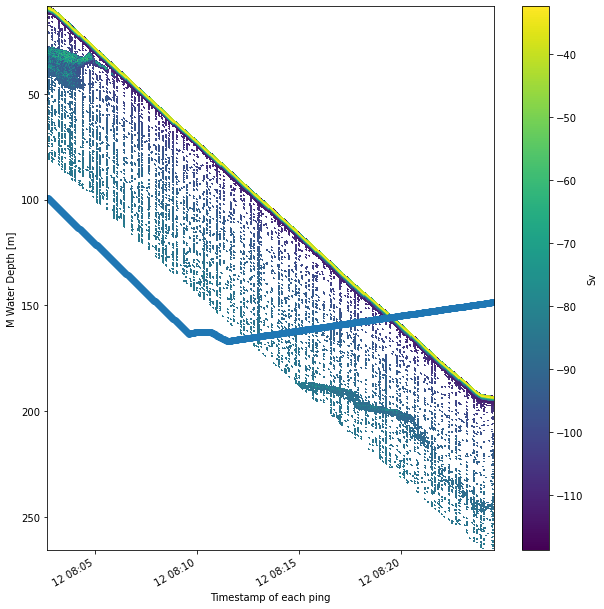

In [6]:

plt.figure(figsize=(10,10))
ds.Sv[0,:,:].plot(x="ping_time", y="bin_depths", yincrease=False)
ds.bottom_depth.plot(marker='o', ls='')


# processing with echopy

try some:
1. seabed masking
1. impluse noise removal
1. swarm detection

In [7]:
from echopy.processing import mask_seabed as  maskSB
from echopy.processing import mask_impulse as mIN
from echopy.processing import mask_shoals as mSH


<ipython-input-8-1b6d3707edbf>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh( ds.ping_time, ds.range[0,:,0], sb)
<ipython-input-8-1b6d3707edbf>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ds.ping_time, ds.range[0,:,0],ds.Sv[0,:,:].T.data )


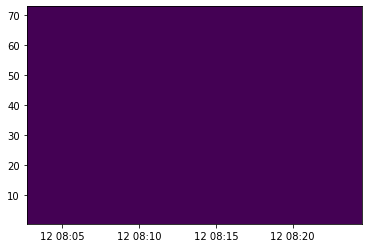

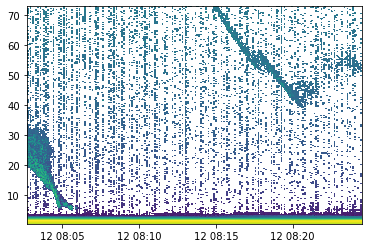

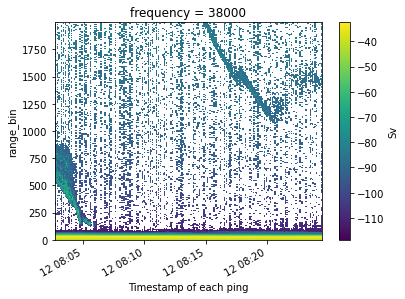

In [8]:
# sb = mask_seabed.deltaSv(ds.Sv[0,:,:].data.T, ds.range[0,:,0].data,
#                       r0=10, thr=-20)

# sb = mask_seabed.maxSv(ds.Sv[0,:,:].data.T, ds.range[0,:,0].data)

sb = maskSB.ariza(ds.Sv[0,:,:].data.T, ds.range[0,:,0].data,
                      dc=3)

# sb = mask_seabed.experimental(ds.Sv[0,:,:].data.T, ds.range[0,:,0].data,
#                       )

plt.pcolormesh( ds.ping_time, ds.range[0,:,0], sb)

plt.figure()
plt.pcolormesh(ds.ping_time, ds.range[0,:,0],ds.Sv[0,:,:].T.data )

plt.figure()

ds.Sv[0,:,:].where(sb.T==0).plot(x="ping_time")

<ipython-input-9-be76a3ba25ae>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ds.ping_time, ds.range[0,:,0], shoal[0] )


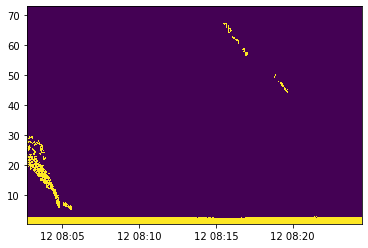

In [9]:
# look for swarms:

# shoal = mSH.weill(ds.Sv[0,:,:].data.T, thr=-70, maxvgap=5, minvlen=1, minhlen=5 )

# sv_no_imp = mIN.wang(ds.Sv[0,:,:].data.T, thr=(-70,-40), erode=[(3,3)],
#                       dilate=[(7,7)], median=[(7,7)])[0]


# plt.pcolormesh(ds.ping_time, ds.range[0,:,0],sv_no_imp )

shoal = mSH.echoview(ds.Sv[0,:,:].data.T,
    np.arange( len(ds.Sv.range_bin )+1),
    np.arange(len(ds.Sv.ping_time)+1),
    thr=-85,
    mincan=(5, 5),
    maxlink=(30, 2),
    minsho=(30, 2),
)


plt.figure()
plt.pcolormesh(ds.ping_time, ds.range[0,:,0], shoal[0] )